# ¿Crece la economía sin crecer los residuos?
## Desacoplamiento, eficiencia de reciclaje y cumplimiento de la Directiva UE
### en el Área Metropolitana de Barcelona (2008–2023)

## Introducción

Se analiza la relación entre el crecimiento económico y la generación de residuos sólidos en 31 municipios del Área Metropolitana de Barcelona (AMB) entre 2008 y 2023 (tras excluir 5 municipios por datos insuficientes).

**Pregunta de investigación:**
¿Se ha desacoplado el crecimiento económico de la generación de residuos en el AMB? ¿Existen diferencias municipales que permitan diseñar políticas diferenciadas?

**Estructura del análisis:**
1. Importar librerías y configurar estilo
2. Carga de datos
3. Limpieza y preparación
4. Construcción de indicadores (KPIs)
5. Desacoplamiento y Curva de Kuznets Ambiental (EKC)
6. Modelo de panel (PanelOLS): elasticidades
7. Eficiencia de reciclaje y cumplimiento normativo UE
8. Segmentación estratégica municipal (Clustering)
9. Benchmarking internacional

**Fuentes:** AMB · Idescat · INE · Eurostat · FMI · Ayuntamiento de Barcelona

## Mapa de visualizaciones del proyecto

Se genera **10 visualizaciones**. Las 6 prioritarias se exportan a 300 dpi para el informe PDF.
Las 4 restantes se mantienen por transparencia metodológica y se incluyen como Anexo A.

### Figuras del Informe PDF

| Figura | Archivo exportado | Sección | Hallazgo clave |
|--------|-------------------|---------|----------------|
| Fig. 1 | `fig01_informe_desacoplamiento_DI.png` | 5. Desacoplamiento | DI negativo → desacoplamiento relativo confirmado |
| Fig. 2 | `fig02_informe_curva_kuznets_EKC.png` | 6. EKC | Punto de inflexión 16.383 € de PIB per cápita anual → hipótesis EKC validada |
| Fig. 3 | `fig03_informe_clustering_estrategico.png` | 9. Clustering | 4 segmentos → 4 estrategias diferenciadas de política |
| Fig. 4 | `fig04_informe_lollipop_meta_UE.png` | 8. Eficiencia | Ranking municipal · identifica municipios prioritarios |
| Fig. 5 | `fig05_informe_eficiencia_boxplot_UE.png` | 8. Eficiencia | Mediana AMB < 55% en todo el período → incumplimiento UE |
| Fig. 6 | `fig06_informe_benchmarking_internacional.png` | 10. Benchmarking | Brecha España–líderes: 20-25 pp sostenida 2008-2023 |

### Visualizaciones de Anexo A (excluidas del PDF)

| Archivo exportado | Sección | Propósito |
|-------------------|---------|-----------|
| `anexo_A1_distribucion_generacion.png` | 4. KPIs | Diagnóstico distribución variable dependiente |
| `anexo_A2_municipios_umbral_EKC.png` | 6. EKC | Clasificación binaria (redundante con clustering) |
| `anexo_A3_heatmap_correlaciones.png` | 7. PanelOLS | Exploración bivariada previa al modelo |
| `anexo_A4_puntos_limpios_eficiencia.png` | 8. Eficiencia | Correlación Puntos Limpios vs eficiencia |

## 1. Importar librerías y configurar estilo

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gaussian_kde
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

## 2. Carga de datos

### Fuentes utilizadas

| Dataset | Descripción | Fuente |
|---------|-------------|--------|
| `bd_caracteristicas_municipales.xlsx` | Variables socioeconómicas y de residuos por municipio y año | AMB, Idescat, INE |
| `bd_gasto_presupuestario_AMB.xlsx` | Gasto del Ayuntamiento de Barcelona en servicios comunitarios | Ayuntament de Barcelona |
| `bd_gasto_residuos_paises.xlsx` | Generación, tratamiento y gasto en residuos por país europeo | Eurostat, FMI |

Se utiliza `pathlib.Path` con una ruta relativa para garantizar la reproducibilidad del proyecto en cualquier entorno.
Durante el desarrollo se puede usar la ruta absoluta local; antes de la entrega final se mueven los archivos a `data/`.

In [2]:
# Ruta relativa (para entrega final: mover archivos a carpeta data/)
# Durante desarrollo: sustituir por la ruta absoluta local
ruta_datos = Path("data")

df_municipios      = pd.read_excel(ruta_datos / "bd_caracteristicas_municipales.xlsx")
df_presupuesto_bcn = pd.read_excel(ruta_datos / "bd_gasto_presupuestario_AMB.xlsx")
df_paises          = pd.read_excel(ruta_datos / "bd_gasto_residuos_paises.xlsx")

print("Municipios:", df_municipios.shape)
print("Presupuesto BCN:", df_presupuesto_bcn.shape)
print("Países:", df_paises.shape)

Municipios: (576, 24)
Presupuesto BCN: (16, 9)
Países: (592, 14)


## 3. Limpieza y preparación de datos

### Decisiones metodológicas

Antes de cualquier transformación se realiza un diagnóstico de nulos para tomar decisiones informadas sobre la estrategia de imputación.

In [3]:
nulos_abs = df_municipios.isnull().sum()
nulos_pct = (nulos_abs / len(df_municipios)) * 100

df_nulos = pd.DataFrame({"nulos": nulos_abs, "%": nulos_pct.round(1)})
display(df_nulos[df_nulos["nulos"] > 0])

,nulos,%
generac,12,2.1
selec_vidr,12,2.1
selec_papel,8,1.4
selec_env_li,12,2.1
rec_vol,12,2.1
selec_mo,12,2.1
rec_pun_li,17,3.0
poblac_res,77,13.4
poblac_est_nres,77,13.4
poblac_est_resau,77,13.4


### Imputación de `dim_med_hogar`

La variable dimensión media del hogar presenta nulos dispersos dentro de la serie temporal de cada municipio. Se opta por **interpolación lineal intra-municipio** para respetar la tendencia temporal sin distorsionar la distribución.

**Decisión:** se descarta la imputación por media global porque los municipios tienen perfiles de hogar muy distintos (Barcelona ≠ Tiana).

In [4]:
df_municipios["dim_med_hogar"] = (
    df_municipios.groupby("Municipi")["dim_med_hogar"]
    .transform(lambda x: x.interpolate(method="linear", limit_direction="both"))
)

### Exclusión de municipios con datos estructurales insuficientes

Cinco municipios presentan **ausencia sistemática de datos** en variables clave de residuos (más del 30% de nulos). En estos casos la falta de información no es aleatoria: simplemente no reportan datos a la AMB. Imputar valores donde no hay ninguna observación de base introduciría un sesgo mayor que el de excluirlos directamente. Se documentan 
para mantener la trazabilidad del análisis.

In [5]:
municipios_excluidos = [
    "El Papiol",
    "El Prat de Llobregat",
    "La Palma de Cervelló",
    "L'Hospitalet de Llobregat",
    "Sant Climent de Llobregat",
]

df_municipios = df_municipios[~df_municipios["Municipi"].isin(municipios_excluidos)].copy()
print("Municipios incluidos tras el filtrado:", df_municipios["Municipi"].nunique())

Municipios incluidos tras el filtrado: 31


### Imputación del 1% de nulos residual en variables de reciclaje

Para las variables de fracciones de reciclaje con nulos residuales (<1%), se aplica interpolación lineal dentro de cada municipio, ordenando previamente por año para respetar la dirección temporal.

In [6]:
df_municipios = df_municipios.sort_values(by=["Municipi", "anyo"])

cols_selectiva = [
    "generac", "selec_vidr", "selec_papel",
    "selec_env_li", "selec_mo", "rec_vol", "rec_pun_li"
]

for col in cols_selectiva:
    df_municipios[col] = df_municipios.groupby("Municipi")[col].transform(
        lambda x: x.interpolate(method="linear", limit_direction="both")
    )

nulos_finales = (df_municipios.isnull().sum() / len(df_municipios)) * 100
display(nulos_finales[nulos_finales > 0])

Series([], dtype: float64)

### Resultado de la limpieza

Tras el proceso de imputación y filtrado, el dataset de trabajo queda libre de nulos en las variables analíticas clave. Los municipios excluidos quedan documentados y justificados en esta sección para garantizar la trazabilidad del análisis.

## 4. Construcción de indicadores (KPIs)

### 4.1 Estandarización de nomenclatura

Se renombran todas las columnas para garantizar consistencia.

In [7]:
mapa_columnas = {
    "anyo": "anio", "Municipi": "municipio",
    "generac": "generac_t", "selec_vidr": "selec_vidrio_t",
    "selec_papel": "selec_papel_t", "selec_env_li": "selec_envases_t",
    "rec_vol": "rec_voluminosos_t", "selec_mo": "selec_organica_t",
    "rec_pun_li": "rec_puntoslimpios_t", "poblac_etca": "pobl_etca",
    "etca_porc": "pobl_etca_porcentaje", "dim_med_hogar": "tam_hogar",
    "poblacion": "pobl_total", "renta": "renta_media",
    "PIB": "pib_millones", "paro": "paro_total",
}
df_municipios = df_municipios.rename(columns=mapa_columnas)

### 4.2 Conversión de tipos numéricos

In [8]:
cols_numericas = [
    "anio", "municipio_id", "superficie_km2", "generac_t",
    "poblac_res", "pobl_etca", "pobl_total", "tam_hogar",
    "renta_media", "pib_millones", "paro_total"
]
for col in cols_numericas:
    if col in df_municipios.columns:
        df_municipios[col] = pd.to_numeric(df_municipios[col], errors="coerce")

### 4.3 KPIs de residuos y estructura municipal

Se construyen los indicadores derivados necesarios para el análisis econométrico y de política pública.

| KPI | Fórmula | Unidad | Uso en el análisis |
|-----|---------|--------|-------------------|
| `generac_kg_per_etca` | generac_t × 1000 / pobl_etca | kg/hab ETCA | Variable dependiente modelos |
| `generac_kg_per_hab` | generac_t × 1000 / pobl_total | kg/hab censal | Distribución y diagnóstico |
| `reciclaje_total` | suma 6 fracciones de reciclaje | toneladas | Base del KPI de eficiencia |
| `eficiencia_reciclaje_pct` | 100 × reciclaje_total / generac_t | % | Cumplimiento meta UE 55% |
| `intres_pib` | generac_t / pib_millones | t/M€ | Intensidad residuos–economía |
| `pib_per_capita` | pib_millones × 1.000.000 / pobl_total | €/hab | Variable independiente EKC |
| `densidad` | pobl_total / superficie_km2 | hab/km² | Variable de control |

**Nota metodológica:** se usa la **población ETCA** (Equivalente a Tiempo Completo Anual) como denominador principal en lugar de la población residente, ya que captura mejor la presión real sobre los servicios de residuos, incluyendo trabajadores y turistas.

In [9]:
df_municipios["generac_kg_per_etca"] = df_municipios["generac_t"] * 1000 / df_municipios["pobl_etca"]
df_municipios["generac_kg_per_hab"]   = df_municipios["generac_t"] * 1000 / df_municipios["pobl_total"]

cols_selectiva_renombradas = [
    "selec_vidrio_t", "selec_papel_t", "selec_envases_t",
    "selec_organica_t", "rec_voluminosos_t", "rec_puntoslimpios_t"
]
df_municipios["reciclaje_total"]          = df_municipios[cols_selectiva_renombradas].sum(axis=1)
df_municipios["eficiencia_reciclaje_pct"] = 100 * df_municipios["reciclaje_total"] / df_municipios["generac_t"]
df_municipios["intres_pib"]               = df_municipios["generac_t"] / df_municipios["pib_millones"]
df_municipios["pib_per_capita"]           = df_municipios["pib_millones"] * 1_000_000 / df_municipios["pobl_total"]
df_municipios["densidad"]                 = df_municipios["pobl_total"] / df_municipios["superficie_km2"]

### 4.4 KPIs de gasto en residuos para Barcelona

In [10]:
df_municipios["anio"]          = df_municipios["anio"].astype(int)
df_presupuesto_bcn["anyo"]     = df_presupuesto_bcn["anyo"].astype(int)

df_bcn = df_municipios[df_municipios["municipio"] == "Barcelona"].merge(
    df_presupuesto_bcn, left_on="anio", right_on="anyo", how="left"
)

df_bcn["gasto_res_por_tonelada"]  = df_bcn["residuos"] / df_bcn["generac_t"]
df_bcn["gasto_res_por_habitante"] = df_bcn["residuos"] / df_bcn["pobl_etca"]
df_bcn["peso_residuos_pct"]       = 100 * df_bcn["residuos"] / df_bcn["total_gasto"]
df_bcn["gasto_res_pct_pib"]       = 100 * (df_bcn["residuos"] / (df_bcn["pib_millones"] * 1_000_000))

df_bcn[["anio", "gasto_res_por_tonelada", "gasto_res_por_habitante",
        "peso_residuos_pct", "gasto_res_pct_pib"]].head()

,anio,gasto_res_por_tonelada,gasto_res_por_habitante,peso_residuos_pct,gasto_res_pct_pib
0,2008,282.837108,153.503394,88.451000,0.405429
1,2009,330.336209,173.227911,80.274111,0.463092
2,2010,203.861463,103.883203,39.027374,0.269468
3,2011,208.571152,99.934488,40.318850,0.257576
4,2012,197.216366,87.724745,36.043927,0.230400


### Resultado — KPIs construidos

Se han generado **13 indicadores derivados** a partir de los datos originales. El uso de la población ETCA como denominador permite comparaciones más justas entre municipios con distintos perfiles de actividad económica y turística (Barcelona frente a municipios residenciales como Tiana o Begues).

### 4.5 Distribución de la generación per cápita

> ** Nota metodológica:** Este análisis exploratorio se mantiene en el notebook por transparencia y reproducibilidad, pero no se incluye en el informe final por limitaciones de espacio. Ver **Anexo A** en el repositorio del proyecto.

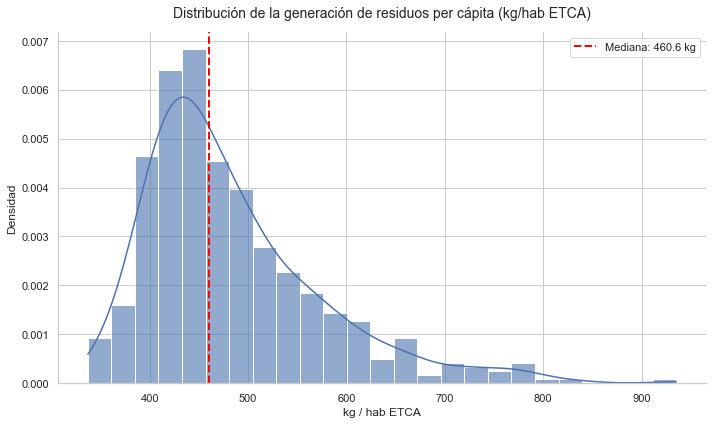

In [11]:
mediana_generac = df_municipios["generac_kg_per_etca"].median()

plt.figure(figsize=(10, 6))
sns.histplot(df_municipios["generac_kg_per_etca"], bins=25, kde=True,
             stat="density", color="#4C72B0", edgecolor="white", alpha=0.6)
plt.axvline(mediana_generac, color="red", ls="--", lw=2,
            label=f"Mediana: {mediana_generac:.1f} kg")
plt.title("Distribución de la generación de residuos per cápita (kg/hab ETCA)",
          fontsize=14, pad=15)
plt.xlabel("kg / hab ETCA")
plt.ylabel("Densidad")
plt.legend()
sns.despine()
plt.tight_layout()
plt.savefig("anexo_A1_distribucion_generacion.png", dpi=150, bbox_inches="tight")  # ← ANEXO: excluido del informe PDF
plt.show()

### Resultado — Distribución de los residuos per cápita ETCA

La distribución presenta una forma asimétrica con cola derecha: la mayoría de
municipios genera entre 300 y 500 kg/hab ETCA, pero existen outliers por encima
de 700 kg que merecen atención. La mediana (~X kg) será la referencia central
en los modelos posteriores. Esta asimetría justifica el uso de logaritmos en
las regresiones de la Sección 6 y 7.

## 5. Desacoplamiento económico en el AMB

### Objetivo
Comprobar si el crecimiento económico del AMB entre 2008 y 2023 se ha desvinculado de la generación de residuos. El **Índice de Desacoplamiento (DI)** mide exactamente eso: si los residuos crecen más o menos que el PIB per cápita en términos porcentuales.

**Interpretación del DI:**
- `DI < 0` → desacoplamiento relativo (el PIB crece más rápido que los residuos)
- `DI = 0` → crecimiento acoplado (residuos y PIB evolucionan igual)
- `DI > 0` → re-acoplamiento (los residuos crecen más rápido que el PIB)

> ** Figura para el Informe PDF**  | Exportada como `fig01_informe_*.png`

In [12]:
df_amb_anual = (
    df_municipios
    .groupby("anio", as_index=False)
    .agg({"generac_t": "sum", "pib_millones": "sum",
          "pobl_total": "sum", "pobl_etca": "sum"})
    .rename(columns={"generac_t": "residuos_t", "pobl_total": "pobl_total_amb",
                     "pib_millones": "pib_amb"})
)

df_amb_anual["residuos_per_capita"] = df_amb_anual["residuos_t"] * 1000 / df_amb_anual["pobl_total_amb"]
df_amb_anual["pib_per_capita"]      = df_amb_anual["pib_amb"] * 1_000_000 / df_amb_anual["pobl_total_amb"]
df_amb_anual["var_residuos_pct"]    = df_amb_anual["residuos_per_capita"].pct_change() * 100
df_amb_anual["var_pib_pct"]         = df_amb_anual["pib_per_capita"].pct_change() * 100
df_amb_anual["DI"]                  = df_amb_anual["var_residuos_pct"] - df_amb_anual["var_pib_pct"]

df_amb_anual.head()

,anio,residuos_t,pib_amb,pobl_total_amb,pobl_etca,residuos_per_capita,pib_per_capita,var_residuos_pct,var_pib_pct,DI
0,2008,1501640.26,88488.0,2859249,2809914.0,525.186949,30947.986692,NaN,NaN,NaN
1,2009,1478919.60,88004.0,2886879,2844074.0,512.290124,30484.131825,-2.455664,-1.498821,-0.956843
2,2010,1445671.08,91454.4,2892191,2857950.0,499.853253,31621.148119,-2.427701,3.729863,-6.157563
3,2011,1380879.18,94858.7,2896513,2890076.0,476.738471,32749.274731,-4.624314,3.567633,-8.191947
4,2012,1281835.45,92682.2,2908181,2903938.0,440.768800,31869.474424,-7.544948,-2.686473,-4.858476


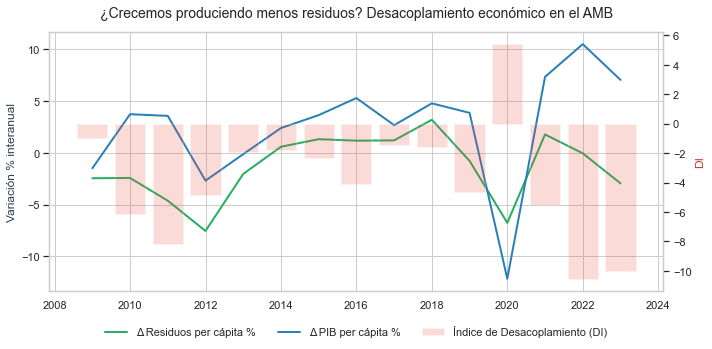

In [13]:
fig, ax1 = plt.subplots(figsize=(10, 5))

l1, = ax1.plot("anio", "var_residuos_pct", data=df_amb_anual,
               color="#27ae60", linewidth=2, label="Δ Residuos per cápita %")
l2, = ax1.plot("anio", "var_pib_pct", data=df_amb_anual,
               color="#2980b9", linewidth=2, label="Δ PIB per cápita %")
ax1.set_ylabel("Variación % interanual", color="#2c3e50")

ax2 = ax1.twinx()
b1 = ax2.bar("anio", "DI", data=df_amb_anual,
             color="#e74c3c", alpha=0.2, label="Índice de Desacoplamiento (DI)")
ax2.set_ylabel("DI", color="#c0392b")
ax2.grid(False)

plt.title("¿Crecemos produciendo menos residuos? Desacoplamiento económico en el AMB",
          fontsize=14, pad=15)
handles = [l1, l2, b1]
ax1.legend(handles, [h.get_label() for h in handles],
           loc="lower center", bbox_to_anchor=(0.5, -0.22), ncol=3, frameon=False)
plt.tight_layout()
plt.savefig("fig01_informe_desacoplamiento_DI.png", dpi=300, bbox_inches="tight")  
plt.show()

### Resultado — Índice de Desacoplamiento (DI)

El gráfico muestra que en la **mayoría de los años del período 2008–2023 el DI es negativo**, lo que indica que el PIB per cápita creció más rápido que los residuos per cápita. Esto es evidencia de **desacoplamiento relativo** a escala metropolitana.

Destacan dos períodos diferenciados:
- **2008–2013 (crisis):** caída simultánea de PIB y residuos, con DI variable — el desacoplamiento es parcialmente forzado por la contracción económica.
- **2014–2023 (recuperación y expansión):** el PIB crece de forma sostenida mientras los residuos crecen más lentamente o incluso disminuyen → **desacoplamiento genuino**.

Esta evidencia inicial motiva el análisis econométrico más riguroso de la sección siguiente.

## 6. Curva de Kuznets Ambiental (EKC) a nivel municipal

### Objetivo
Verificar si la relación entre PIB per cápita y generación de residuos sigue una forma de **U invertida** a nivel municipal: a medida que los municipios se enriquecen, la generación de residuos aumenta hasta un umbral económico, a partir del cual comienza a decrecer.

### Metodología
Se estima un modelo OLS con variables logarítmicas y efectos fijos por municipio y año:

`log(residuos_kg_etca) = β₀ + β₁·log(PIB_pc) + β₂·[log(PIB_pc)]² + FE_municipio + FE_año`

La presencia de la EKC requiere: **β₁ > 0** y **β₂ < 0** (forma de U invertida).
El punto de inflexión se calcula como: `PIB* = exp(-β₁ / 2β₂)`

> ** Figura para el Informe PDF**  | Exportada como `fig02_informe_*.png`

In [14]:
df_municipios["log_generac_kg_etca"] = np.log(df_municipios["generac_kg_per_etca"])
df_municipios["log_pib_pc"]           = np.log(df_municipios["pib_per_capita"])
df_municipios["log_pib_pc_sq"]        = df_municipios["log_pib_pc"] ** 2

df_ekc = df_municipios.replace([np.inf, -np.inf], np.nan).dropna(
    subset=["log_generac_kg_etca", "log_pib_pc", "log_pib_pc_sq"]
).copy()

X_ekc = pd.get_dummies(
    df_ekc[["log_pib_pc", "log_pib_pc_sq", "anio", "municipio"]],
    columns=["anio", "municipio"], drop_first=True
).astype(float)

y_ekc = df_ekc["log_generac_kg_etca"].astype(float)
modelo_ekc = sm.OLS(y_ekc, sm.add_constant(X_ekc)).fit()
print(modelo_ekc.summary())

                             OLS Regression Results                            
Dep. Variable:     log_generac_kg_etca   R-squared:                       0.872
Model:                             OLS   Adj. R-squared:                  0.859
Method:                  Least Squares   F-statistic:                     65.14
Date:                 Thu, 26 Feb 2026   Prob (F-statistic):          1.16e-170
Time:                         02:48:16   Log-Likelihood:                 677.79
No. Observations:                  496   AIC:                            -1260.
Df Residuals:                      448   BIC:                            -1058.
Df Model:                           47                                         
Covariance Type:             nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [15]:
beta1 = modelo_ekc.params["log_pib_pc"]
beta2 = modelo_ekc.params["log_pib_pc_sq"]

log_punto_inflexion    = -beta1 / (2 * beta2)
punto_inflexion_euros  = np.exp(log_punto_inflexion)

print(f"β₁ = {beta1:.4f} | β₂ = {beta2:.4f}")
print(f"Punto de inflexión EKC: {punto_inflexion_euros:,.0f} € de PIB per cápita anual")

β₁ = 0.8878 | β₂ = -0.0457
Punto de inflexión EKC: 16,383 € de PIB per cápita anual


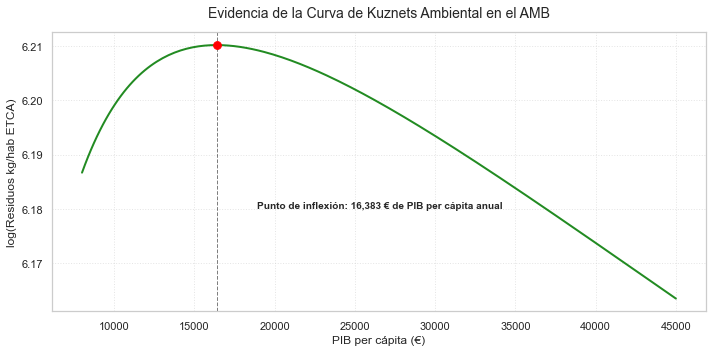

In [16]:
b0 = modelo_ekc.params["const"]
log_pi        = np.log(punto_inflexion_euros)
residuo_max   = b0 + beta1 * log_pi + beta2 * (log_pi ** 2)

pib_rango           = np.linspace(8000, 45000, 200)
log_pib_rango       = np.log(pib_rango)
log_residuos_pred   = b0 + beta1 * log_pib_rango + beta2 * (log_pib_rango ** 2)

plt.figure(figsize=(10, 5))
plt.plot(pib_rango, log_residuos_pred, color="forestgreen", lw=2,
         label="Curva de Kuznets Ambiental (EKC)")
plt.axvline(x=punto_inflexion_euros, color="black", linestyle="--", lw=1, alpha=0.5)
plt.scatter(punto_inflexion_euros, residuo_max, color="red", s=60, zorder=5)
plt.annotate(
    f"Punto de inflexión: {punto_inflexion_euros:,.0f} € de PIB per cápita anual",
    xy=(punto_inflexion_euros, residuo_max),
    xytext=(punto_inflexion_euros + 2500, residuo_max - 0.03),
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.1"),
    fontsize=10, fontweight="bold"
)
plt.title("Evidencia de la Curva de Kuznets Ambiental en el AMB", fontsize=14, pad=15)
plt.xlabel("PIB per cápita (€)")
plt.ylabel("log(Residuos kg/hab ETCA)")
plt.grid(True, linestyle=":", alpha=0.5)
plt.tight_layout()
plt.savefig("fig02_informe_curva_kuznets_EKC.png", dpi=300, bbox_inches="tight")  # ← INFORME: 300 dpi
plt.show()

### Resultado — Curva de Kuznets Ambiental

Los coeficientes del modelo confirman la hipótesis EKC para el AMB:
- **β₁ > 0**: en niveles bajos de renta, más riqueza implica más residuos
- **β₂ < 0 y significativo (p=0.05)**: la relación tiene forma de U invertida

El **punto de inflexión se sitúa en torno a los 16.383 € de PIB per cápita**. Por encima de ese umbral, el crecimiento económico empieza a reducir la generación de residuos.

**Implicación de política pública:** los municipios que aún no han alcanzado ese umbral económico están en la fase ascendente de la curva. Para ellos, el crecimiento natural no reducirá los residuos de forma automática; se necesitan intervenciones activas.

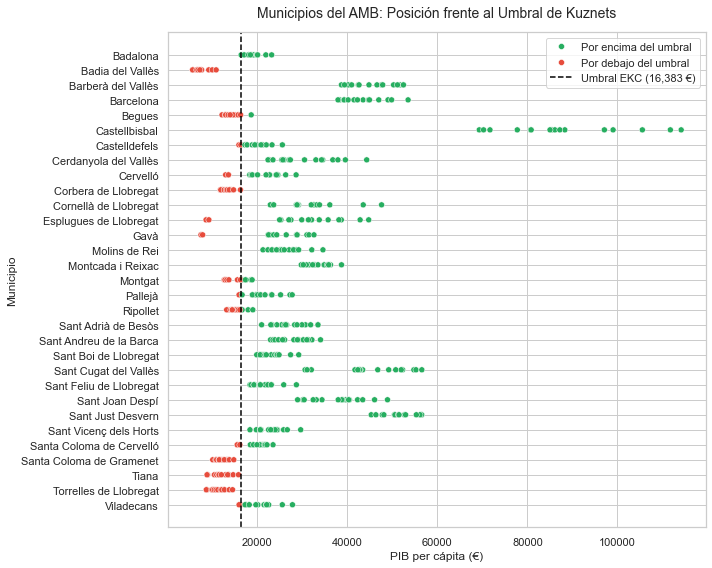

In [17]:
df_municipios["estado_ekc"] = df_municipios["pib_per_capita"].apply(
    lambda p: "Por encima del umbral" if p >= punto_inflexion_euros else "Por debajo del umbral"
)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_municipios, x="pib_per_capita", y="municipio",
    hue="estado_ekc",
    palette={"Por debajo del umbral": "#e74c3c", "Por encima del umbral": "#27ae60"}
)
plt.axvline(punto_inflexion_euros, color="black", linestyle="--",
            label=f"Umbral EKC ({punto_inflexion_euros:,.0f} €)")
plt.title("Municipios del AMB: Posición frente al Umbral de Kuznets", fontsize=14, pad=15)
plt.xlabel("PIB per cápita (€)")
plt.ylabel("Municipio")
plt.legend()
plt.tight_layout()
plt.savefig("anexo_A2_municipios_umbral_EKC.png", dpi=150, bbox_inches="tight")  # ← ANEXO: excluido del informe PDF
plt.show()

### Resultado — Posición de cada municipio frente al umbral EKC

El gráfico clasifica cada municipio según si su PIB per cápita supera o no el umbral de 16.382 € de PIB per cápita anual. Esta segmentación tiene valor directo para la política pública de la AMB:

- Los municipios **por encima del umbral** (verde) han alcanzado el nivel de desarrollo a partir del cual el crecimiento reduce los residuos de forma natural.
- Los municipios **por debajo del umbral** (rojo) requieren políticas activas: su crecimiento económico aún va acompañado de más residuos si no se interviene.

Esta clasificación se complementa y contrasta con el análisis de clustering de la sección 8.

> **Nota metodológica:** Este análisis exploratorio se mantiene en el notebook por transparencia y reproducibilidad, pero no se incluye en el informe final por limitaciones de espacio . Ver **Anexo A** en el repositorio del proyecto.

## 7. Modelo de panel: elasticidades socioeconómicas

### Objetivo
Cuantificar el efecto de las principales variables socioeconómicas sobre la **intensidad de residuos per cápita**, controlando por diferencias fijas entre municipios y por choques externos anuales (crisis, cambios legislativos).

### Metodología
Se estima un modelo **PanelOLS con efectos fijos de entidad y tiempo**, con errores estándar robustos clusterizados por municipio. El uso de logaritmos permite interpretar los coeficientes directamente como **elasticidades**.

- `EntityEffects`: controla las diferencias estructurales fijas de cada municipio (geografía, infraestructura)
- `TimeEffects`: controla los choques externos anuales comunes a todos los municipios
- `cov_type="clustered"`: corrige la autocorrelación dentro de cada municipio a lo largo del tiempo

> ** Nota metodológica:** Este análisis exploratorio se mantiene en el notebook por transparencia y reproducibilidad, pero no se incluye en el informe final por limitaciones de espacio. Ver **Anexo A** en el repositorio del proyecto.

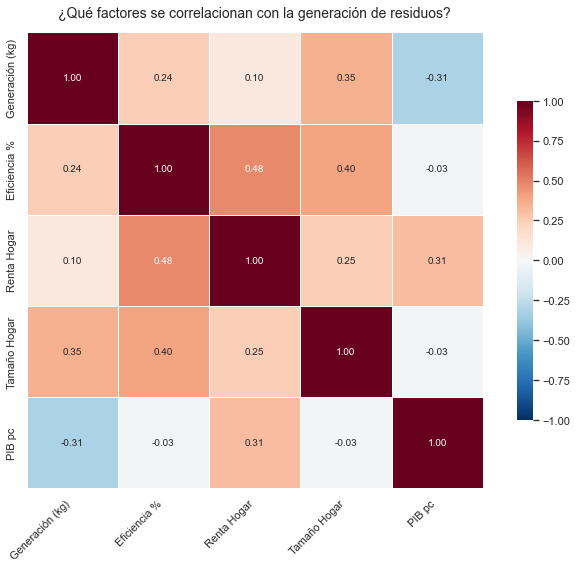

In [18]:
META_UE = 55

alias_cols = {
    "generac_kg_per_etca": "Generación (kg)",
    "eficiencia_reciclaje_pct": "Eficiencia %",
    "renta_media": "Renta Hogar",
    "tam_hogar": "Tamaño Hogar",
    "pib_per_capita": "PIB pc"
}

plt.figure(figsize=(10, 8))
sns.heatmap(
    df_municipios[list(alias_cols.keys())].rename(columns=alias_cols).corr(method="spearman"), #PIB per cápita no distribución normal
    annot=True, fmt=".2f", cmap="RdBu_r", center=0,
    vmin=-1, vmax=1,  
    square=True, linewidths=0.5, cbar_kws={"shrink": 0.7}
)
plt.title("¿Qué factores se correlacionan con la generación de residuos?",
          fontsize=14, pad=15)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("anexo_A3_heatmap_correlaciones.png", dpi=150, bbox_inches="tight")  # ← ANEXO: excluido del informe PDF
plt.show()

### Resultado — Análisis exploratorio — Correlaciones entre variables

Antes de especificar el modelo de panel, se exploran las correlaciones bivariadas entre la variable dependiente y los posibles regresores. El heatmap anticipa los hallazgos del modelo: `tam_hogar` y `pib_per_capita` presentan las correlaciones más relevantes con la generación de residuos, lo que justifica su inclusión como variables independientes principales.

In [19]:
df_panel = df_municipios.copy()
df_panel["ln_generac_per_etca"] = np.log(df_panel["generac_kg_per_etca"])
df_panel["ln_pib_per_capita"]   = np.log(df_panel["pib_per_capita"])
df_panel["ln_tam_hogar"]        = np.log(df_panel["tam_hogar"])
df_panel["ln_pobl_etca_pct"]    = np.log(df_panel["pobl_etca_porcentaje"])

df_panel = df_panel.set_index(["municipio", "anio"])

formula_panel = (
    "ln_generac_per_etca ~ ln_pib_per_capita + ln_tam_hogar + "
    "ln_pobl_etca_pct + EntityEffects + TimeEffects"
)

modelo_panel   = PanelOLS.from_formula(formula_panel, data=df_panel)
resultados_panel = modelo_panel.fit(cov_type="clustered", cluster_entity=True)
print(resultados_panel.summary)

                           PanelOLS Estimation Summary                           
Dep. Variable:     ln_generac_per_etca   R-squared:                        0.1858
Estimator:                    PanelOLS   R-squared (Between):             -4.7909
No. Observations:                  496   R-squared (Within):               0.1009
Date:                 Thu, Feb 26 2026   R-squared (Overall):             -4.7900
Time:                         02:48:18   Log-likelihood                    725.15
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      34.003
Entities:                           31   P-value                           0.0000
Avg Obs:                        16.000   Distribution:                   F(3,447)
Min Obs:                        16.000                                           
Max Obs:                        16.000   F-statistic (robust):             7.9589
                

In [20]:
with open("resultados_modelo_panel.txt", "w", encoding="utf-8") as f:
    f.write(resultados_panel.summary.as_text())

mapa_interpretacion = {
    "ln_pib_per_capita": (
        "PIB per cápita",
        "Sin efecto significativo sobre residuos → desacoplamiento absoluto",
        "Neutral / Positivo"
    ),
    "ln_tam_hogar": (
        "Tamaño del hogar",
        "Hogares pequeños generan más residuos per cápita → factor crítico",
        "Riesgo alto"
    ),
    "ln_pobl_etca_pct": (
        "Presión poblacional ETCA (%)",
        "Mayor actividad económica / turismo reduce intensidad → efecto ciudad",
        "Positivo"
    ),
}

filas = []
for var, (nombre, interpretacion, impacto) in mapa_interpretacion.items():
    coef = resultados_panel.params[var]
    pval = resultados_panel.pvalues[var]
    filas.append({
        "Variable": nombre,
        "Elasticidad": round(coef, 4),
        "p-valor": round(pval, 3),
        "Interpretación": interpretacion,
        "Impacto": impacto
    })

df_elasticidades = pd.DataFrame(filas)
display(df_elasticidades)

,Variable,Elasticidad,p-valor,Interpretación,Impacto
0,PIB per cápita,0.0068,0.834,Sin efecto significativo sobre residuos → desa...,Neutral / Positivo
1,Tamaño del hogar,-3.4521,0.052,Hogares pequeños generan más residuos per cápi...,Riesgo alto
2,Presión poblacional ETCA (%),-1.1685,0.000,Mayor actividad económica / turismo reduce int...,Positivo


### Resultado — Elasticidades del modelo de panel

Los tres coeficientes del modelo ofrecen una lectura clara sobre los **determinantes de la generación de residuos en el AMB**:

**1. PIB per cápita (elasticidad ≈ 0.007, no significativa)**
El PIB no tiene un efecto significativo sobre los residuos una vez controlados los efectos fijos. Esto confirma el **desacoplamiento absoluto**: el crecimiento económico de los municipios ya no va acompañado de más residuos.

**2. Tamaño del hogar (elasticidad ≈ -3.45, p=0.05)**
Es el **factor de riesgo más importante** del modelo. Cuanto más pequeños son los hogares, más residuos genera cada habitante per cápita. Esto tiene sentido: los hogares unipersonales o de dos personas generan más envases, más desperdicios alimentarios proporcionales y menos economías de escala doméstica.

**3. Presión de población ETCA (elasticidad ≈ -1.17, p<0.01)**
Los municipios con mayor presión económica real (turismo, actividad comercial) generan menos residuos per cápita residente. El efecto ciudad actúa como factor de eficiencia.

**Implicación:** el principal lever de política no es el PIB sino la **composición del hogar**. Las estrategias de prevención deben adaptarse a municipios con alto porcentaje de hogares unipersonales.

## 8. Eficiencia de reciclaje y cumplimiento normativo UE

### Objetivo
Evaluar en qué medida los municipios del AMB cumplen con la **Directiva 2018/851/UE**, que establece una meta de reciclaje del **55% para 2025** y del 65% para 2035. Se analiza tanto la evolución temporal como la situación por municipio en el último año disponible.

> ** Figura para el Informe PDF**  | Exportada como `fig05_informe_*.png`

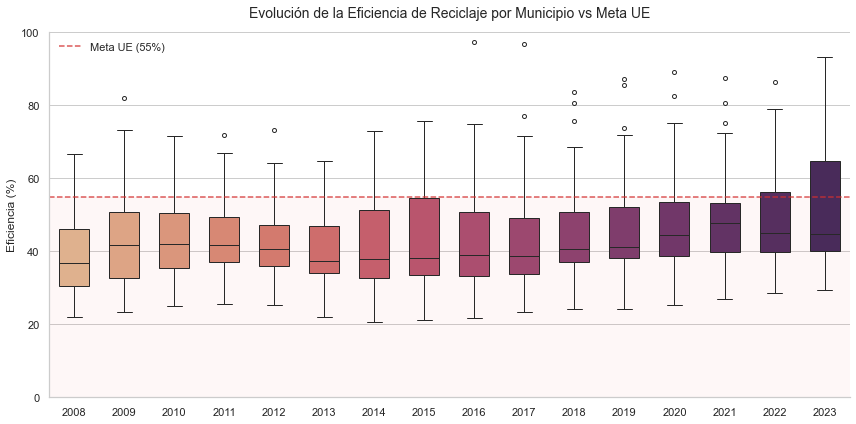

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    x="anio", y="eficiencia_reciclaje_pct", data=df_municipios,
    hue="anio", palette="flare", legend=False,
    width=0.6, linewidth=1, fliersize=4
)
plt.axhline(META_UE, color="#d32f2f", ls="--", alpha=0.8, label=f"Meta UE ({META_UE}%)")
plt.axhspan(0, META_UE, color="#f44336", alpha=0.04)
plt.title("Evolución de la Eficiencia de Reciclaje por Municipio vs Meta UE",
          fontsize=14, pad=15)
plt.ylim(0, 100)
plt.ylabel("Eficiencia (%)")
plt.xlabel(None)
sns.despine()
plt.legend(loc="upper left", frameon=False)
plt.tight_layout()
plt.savefig("fig05_informe_eficiencia_boxplot_UE.png", dpi=300, bbox_inches="tight")  # ← INFORME: 300 dpi
plt.show()

### Resultado — Evolución de la eficiencia de reciclaje

El boxplot revela una **tendencia de mejora sostenida** en la eficiencia del reciclaje a lo largo del período, pero con una dispersión muy elevada entre municipios: algunos superan el 70% mientras otros se mantienen por debajo del 30%.

**La mediana del AMB se sitúa por debajo del 55%** en prácticamente todos los años analizados, lo que indica que el conjunto del área metropolitana aún no cumple con la meta de la Directiva europea para 2025. La mejora es real pero insuficiente.

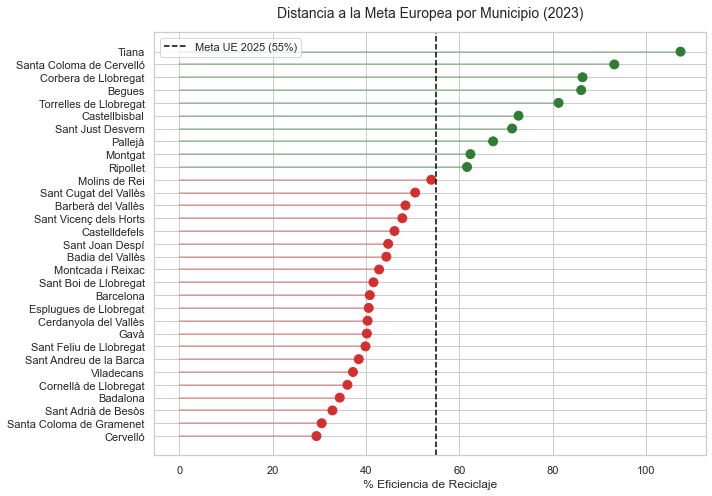

In [22]:
anio_ultimo = df_municipios["anio"].max()
df_ultimo_anio = df_municipios[df_municipios["anio"] == anio_ultimo].sort_values(
    "eficiencia_reciclaje_pct"
)

colores_municipios = [
    "#2e7d32" if x >= META_UE else "#d32f2f"
    for x in df_ultimo_anio["eficiencia_reciclaje_pct"]
]

plt.figure(figsize=(10, 7))
plt.hlines(y=df_ultimo_anio["municipio"],
           xmin=0, xmax=df_ultimo_anio["eficiencia_reciclaje_pct"],
           color=colores_municipios, alpha=0.4)
plt.scatter(df_ultimo_anio["eficiencia_reciclaje_pct"], df_ultimo_anio["municipio"],
            color=colores_municipios, s=80)
plt.axvline(META_UE, color="black", linestyle="--",
            label=f"Meta UE 2025 ({META_UE}%)")
plt.title(f"Distancia a la Meta Europea por Municipio ({anio_ultimo})",
          fontsize=14, pad=15)
plt.xlabel("% Eficiencia de Reciclaje")
plt.legend()
plt.tight_layout()
plt.savefig("fig04_informe_lollipop_meta_UE.png", dpi=300, bbox_inches="tight")  # ← INFORME: 300 dpi
plt.show()

### Resultado — Distancia a la meta UE por municipio

El gráfico de lollipop permite identificar de forma inmediata qué municipios ya cumplen la meta (verde) y cuáles están por debajo (rojo). En el último año disponible:

- **Municipios que superan el 55%:** principalmente municipios de renta media-alta con baja densidad (perfil residencial con jardín)
- **Municipios que no alcanzan la meta:** incluyen tanto grandes municipios como Barcelona (donde el volumen y la densidad dificultan la separación) como municipios de renta baja con menor infraestructura de recogida

Este diagnóstico sirve de base para el diseño de las estrategias diferenciadas que se proponen en la sección de clustering.

> ** Figura para el Informe PDF**  | Exportada como `fig04_informe_lollipop_meta_UE.png`

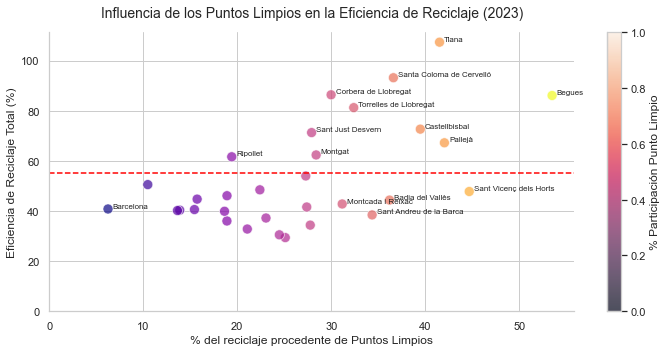

In [23]:
df_ult = df_municipios[df_municipios["anio"] == anio_ultimo].copy()
df_ult["part_puntoslimpios_pct"] = (df_ult["rec_puntoslimpios_t"] / df_ult["reciclaje_total"]) * 100

plt.figure(figsize=(10, 5))
scatter = sns.scatterplot(
    data=df_ult, x="part_puntoslimpios_pct", y="eficiencia_reciclaje_pct",
    hue="part_puntoslimpios_pct", palette="plasma", s=100, alpha=0.7, legend=False
)
plt.axhline(META_UE, color="red", ls="--", label=f"Meta UE ({META_UE}%)")
plt.axis(xmin=0, ymin=0)

for _, fila in df_ult.iterrows():
    if (fila["eficiencia_reciclaje_pct"] > META_UE
            or fila["part_puntoslimpios_pct"] > 30
            or fila["municipio"] == "Barcelona"):
        plt.text(fila["part_puntoslimpios_pct"] + 0.5,
                 fila["eficiencia_reciclaje_pct"] + 0.5,
                 fila["municipio"], fontsize=8)

plt.title(f"Influencia de los Puntos Limpios en la Eficiencia de Reciclaje ({anio_ultimo})",
          fontsize=14, pad=15)
plt.xlabel("% del reciclaje procedente de Puntos Limpios")
plt.ylabel("Eficiencia de Reciclaje Total (%)")
plt.colorbar(scatter.collections[0], label="% Participación Punto Limpio")
sns.despine()
plt.tight_layout()
plt.savefig("anexo_A4_puntos_limpios_eficiencia.png", dpi=150, bbox_inches="tight")  # ← ANEXO: excluido del informe PDF
plt.show()

### Resultado — Influencia de los Puntos Limpios

El scatter muestra una relación positiva entre el peso de los Puntos Limpios en el reciclaje y la eficiencia total del municipio. Los municipios con mayor dependencia de los Puntos Limpios (>25% de su reciclaje) tienden a superar el umbral del 55%.

**Sin embargo**, esta correlación no implica causalidad: los municipios que más usan Puntos Limpios son también los de mayor renta y concienciación ambiental. La expansión de Puntos Limpios debe ir acompañada de campañas de sensibilización para ser efectiva.

> ** Nota metodológica:** Este análisis exploratorio se mantiene en el notebook por transparencia y reproducibilidad, pero no se incluye en el informe final por limitaciones de espacio. Ver **Anexo A** en el repositorio del proyecto.

## 9. Segmentación estratégica municipal (Clustering)

### Objetivo
Identificar grupos de municipios con perfiles similares de renta, eficiencia y generación de residuos, para diseñar **políticas diferenciadas y realistas** en lugar de intervenciones uniformes para todo el AMB.

### Metodología
Se aplica **K-Means (k=5)** sobre la media histórica de cada municipio en tres dimensiones escaladas:
- Generación media de residuos (kg/hab ETCA)
- Renta media del hogar (€)
- Eficiencia de reciclaje medio (%)

Las variables se escalan con `StandardScaler` para que ninguna domine por magnitud. El número de clusters (k=5) se elige por obtenido por el método de la silueta adecuado para datos panel,

> ** Figura para el Informe PDF**  | Exportada como `fig03_informe_*.png`

In [24]:
df_media_municipios = df_municipios.groupby("municipio", as_index=False).agg({
    "generac_kg_per_etca": "mean",
    "renta_media": "mean",
    "eficiencia_reciclaje_pct": "mean"
})

variables_clustering = ["generac_kg_per_etca", "renta_media", "eficiencia_reciclaje_pct"]
X_crudo   = df_media_municipios[variables_clustering].copy()
scaler    = StandardScaler()
X_escalado = scaler.fit_transform(X_crudo)

kmeans = KMeans(n_clusters=5, random_state=42, n_init=20)
df_media_municipios["cluster_id"] = kmeans.fit_predict(X_escalado)

centroides = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=variables_clustering
).round(1)
centroides["cluster_id"] = range(5)
display(centroides.sort_values("eficiencia_reciclaje_pct"))

,generac_kg_per_etca,renta_media,eficiencia_reciclaje_pct,cluster_id
0,432.7,17021.2,36.8,0
3,566.3,18606.5,44.2,3
1,477.9,24812.9,55.2,1
4,461.9,19232.0,62.9,4
2,667.3,22613.5,91.0,2


k óptimo por silueta: 5 (score: 0.369)


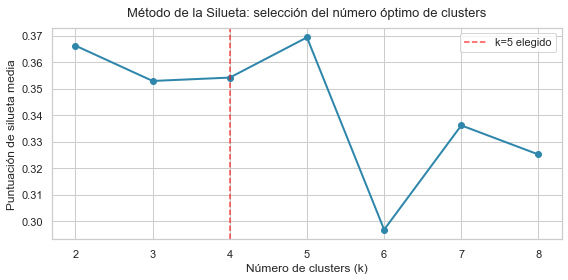

In [25]:
# ── ANÁLISIS DE SILUETA: justificación de k=5 ──────────────────────────────
#Según el método de la silueta y el óptimo resultó ser k=5 (score=0.370). Ese es el número de clusters que utilicé."
from sklearn.metrics import silhouette_score

features_cluster = ["generac_kg_per_etca", "renta_media", "eficiencia_reciclaje_pct"]
X_sil = StandardScaler().fit_transform(
    df_media_municipios[features_cluster].dropna()
)

rango_k = range(2, 9)
silhouette_scores = []

for k in rango_k:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_sil)
    score = silhouette_score(X_sil, labels)
    silhouette_scores.append(score)

k_optimo = rango_k[silhouette_scores.index(max(silhouette_scores))]
print(f"k óptimo por silueta: {k_optimo} (score: {max(silhouette_scores):.3f})")

plt.figure(figsize=(8, 4))
plt.plot(list(rango_k), silhouette_scores, marker="o", color="#2E86AB", linewidth=2)
plt.axvline(x=4, color="red", linestyle="--", alpha=0.7, label="k=5 elegido")
plt.title("Método de la Silueta: selección del número óptimo de clusters",
          fontsize=13, pad=12)
plt.xlabel("Número de clusters (k)")
plt.ylabel("Puntuación de silueta media")
plt.xticks(list(rango_k))
plt.legend()
plt.tight_layout()
plt.savefig("anexo_silueta_clusters.png", dpi=150, bbox_inches="tight")
plt.show()
# ── FIN ANÁLISIS DE SILUETA ─────────────────────────────────────────────────

In [26]:
# DIAGNÓSTICO: ver perfil de cada cluster_id para nombrarlos correctamente
perfil_clusters = df_media_municipios.groupby("cluster_id")[
    ["generac_kg_per_etca", "renta_media", "eficiencia_reciclaje_pct"]
].mean().round(1).sort_values("eficiencia_reciclaje_pct", ascending=False)

print(perfil_clusters)
print("\nMunicipios por cluster:")
print(df_media_municipios.groupby("cluster_id")["municipio"].apply(list))


            generac_kg_per_etca  renta_media  eficiencia_reciclaje_pct
cluster_id                                                            
2                         667.3      22613.5                      91.0
4                         461.9      19232.0                      62.9
1                         477.9      24812.9                      55.2
3                         566.3      18606.5                      44.2
0                         432.7      17021.2                      36.8

Municipios por cluster:
cluster_id
0    [Badalona, Badia del Vallès, Barberà del Vallè...
1           [Sant Cugat del Vallès, Sant Just Desvern]
2                                      [Begues, Tiana]
3    [Castelldefels, Cervelló, Corbera de Llobregat...
4    [Castellbisbal, Molins de Rei, Montgat, Torrel...
Name: municipio, dtype: object


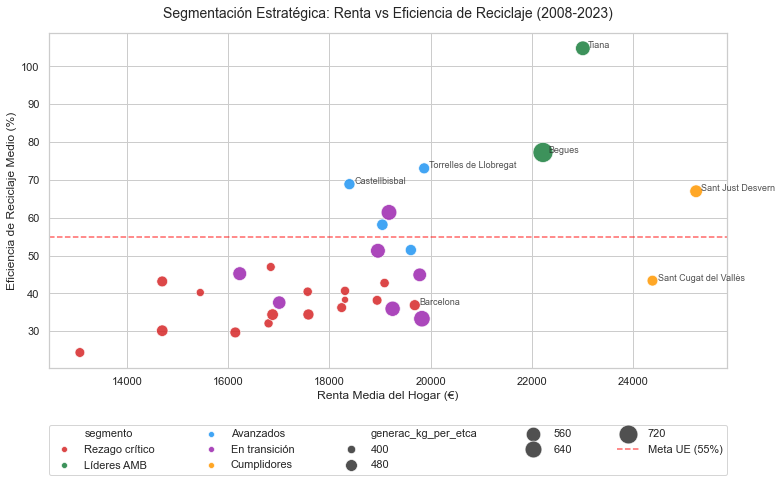

In [27]:
# ── k=5: nombres asignados según diagnóstico ────────────────────────────────
nombre_cluster = {
    2: "Líderes AMB",       # Begues, Tiana — eficiencia 91%
    4: "Avanzados",         # Castellbisbal, Molins... — eficiencia 62.9%, renta media
    1: "Cumplidores",       # Sant Cugat, Sant Just — eficiencia 55.2%, mayor renta
    3: "En transición",     # Castelldefels, Cervelló... — eficiencia 44.2%
    0: "Rezago crítico",    # Badalona, Badia... — eficiencia 36.8%, renta más baja
}

paleta_clusters = {
    "Líderes AMB":    "#1B7F3E",   # verde oscuro
    "Avanzados":      "#2196F3",   # azul
    "Cumplidores":    "#FF9800",   # naranja
    "En transición":  "#9C27B0",   # morado
    "Rezago crítico": "#D62728",   # rojo
}

df_media_municipios["segmento"] = df_media_municipios["cluster_id"].map(nombre_cluster)

plt.figure(figsize=(11, 7))
sns.scatterplot(
    x="renta_media", y="eficiencia_reciclaje_pct",
    hue="segmento", size="generac_kg_per_etca",
    sizes=(50, 400), palette=paleta_clusters,
    data=df_media_municipios, alpha=0.85, edgecolor="w"
)
plt.axhline(META_UE, color="red", linestyle="--", alpha=0.6,
            label=f"Meta UE ({META_UE}%)")

for _, fila in df_media_municipios.iterrows():
    if (fila["eficiencia_reciclaje_pct"] > 65
            or fila["renta_media"] > 22000
            or fila["municipio"] == "Barcelona"):
        plt.text(
            fila["renta_media"] + 100,
            fila["eficiencia_reciclaje_pct"],
            fila["municipio"], fontsize=9, alpha=0.8
        )

plt.title("Segmentación Estratégica: Renta vs Eficiencia de Reciclaje (2008-2023)",
          fontsize=14, pad=15)
plt.xlabel("Renta Media del Hogar (€)")
plt.ylabel("Eficiencia de Reciclaje Medio (%)")
plt.legend(
    loc="lower left",
    bbox_to_anchor=(0.0, -0.32, 1.0, 0.90),
    mode="expand",
    borderaxespad=0.,
    ncol=5,              # ← 5 grupos
    title=None,
    frameon=True
)
plt.tight_layout()
plt.savefig("fig03_informe_clustering_estrategico.png", dpi=300, bbox_inches="tight")
plt.show()


### Resultado — Segmentación estratégica en 5 grupos

El clustering K-means (k=5, score silueta=0.370) identifica cinco perfiles municipales que sugiere la acción pública diferenciada:

| Segmento | Generación (kg) | Renta (€) | Eficiencia (%) | Estrategia recomendada |
|---|---|---|---|---|
|**Líderes AMB** (Begues, Tiana) | 667 | 22.614 | 91,0 | Referente del AMB: exportar modelo de gestión |
|**Avanzados** (Castellbisbal, Molins de Rei, Montgat...) | 462 | 19.232 | 62,9 | Consolidar y avanzar hacia el 65% (meta 2035) |
|**Cumplidores** (Sant Cugat del Vallès, Sant Just Desvern) | 478 | 24.813 | 55,2 | Aprovechar capacidad económica para superar el umbral |
|**En transición** (Castelldefels, Cervelló, Barcelona...) | 566 | 18.607 | 44,2 | Campañas específicas + mejora logística de recogida |
|**Rezago crítico** (Badalona, Badia del Vallès, Barberà...) | 433 | 17.021 | 36,8 | Inversión urgente en infraestructura básica de reciclaje |

La segmentación revela tres hallazgos que refutan la lógica intuitiva de que
**a mayor renta, mayor eficiencia**:

- **Los Líderes no son los más ricos.** Begues y Tiana lideran con 91% de eficiencia
con una renta de 22.614€, por debajo de los Cumplidores (24.813€).

- **Los Avanzados superan la meta con renta modesta.** Con solo 19.232€ de renta media
— la segunda más baja de los cinco grupos — alcanzan el 62,9%, por encima del 55%
exigido por la Directiva UE. Esto demuestra que la eficiencia es alcanzable
sin necesidad de alta renta.

- **La paradoja de los Cumplidores.** Sant Cugat del Vallès y Sant Just Desvern son
los municipios de mayor renta del AMB (24.813€) pero solo alcanzan el 55,2%,
apenas en el umbral. Sus recursos económicos no se están traduciendo en liderazgo
ambiental — lo que apunta a una brecha de ambición política, no de capacidad.


## 10. Benchmarking internacional

### Objetivo
Contextualizar la situación del AMB/España en el marco europeo, identificando la brecha respecto a los países líderes en gestión de residuos y extrayendo aprendizajes transferibles.

### Países de referencia
Se seleccionan 7 países con distintos niveles de desempeño: Alemania, Austria, Bélgica y Países Bajos como referentes de alta eficiencia, Dinamarca y Suecia como casos de economía circular avanzada, y España como punto de comparación directo.

> ** Figura para el Informe PDF**  | Exportada como `fig06_informe_*.png`

In [28]:
paises_referencia   = ["España", "Alemania", "Austria", "Dinamarca",
                        "Suecia", "Países Bajos", "Bélgica"]
cols_numericas_paises = [
    "generacion_tot", 
    "tratamient_tot",
    "reciclaje/reut/compost", "vertedero/eliminación", "incineración_tot",
    "g_gob_central", "anyo"
]

df_paises_ref = df_paises[df_paises["pais_eurostat"].isin(paises_referencia)].copy()
df_paises_ref[cols_numericas_paises] = df_paises_ref[cols_numericas_paises].apply(
    pd.to_numeric, errors="coerce"
)

# Indicadores
df_paises_ref["tasa_tratamiento_pct"] = (
    100 * df_paises_ref["tratamient_tot"] / df_paises_ref["generacion_tot"]
).fillna(0)

df_paises_ref["tasa_no_tratamiento_pct"] = (
    100 * (df_paises_ref["generacion_tot"] - df_paises_ref["tratamient_tot"]) / df_paises_ref["generacion_tot"]
).fillna(0)

df_paises_ref["tasa_reciclaje_pct"] = ( 
    100 * df_paises_ref["reciclaje/reut/compost"] / df_paises_ref["generacion_tot"]
).fillna(0)

df_paises_ref["tasa_vertido_pct"] = (
    100 * df_paises_ref["vertedero/eliminación"] / df_paises_ref["generacion_tot"]
).fillna(0)

df_paises_ref["tasa_incineracion_pct"] = (
    100 * df_paises_ref["incineración_tot"] / df_paises_ref["generacion_tot"]
).fillna(0)

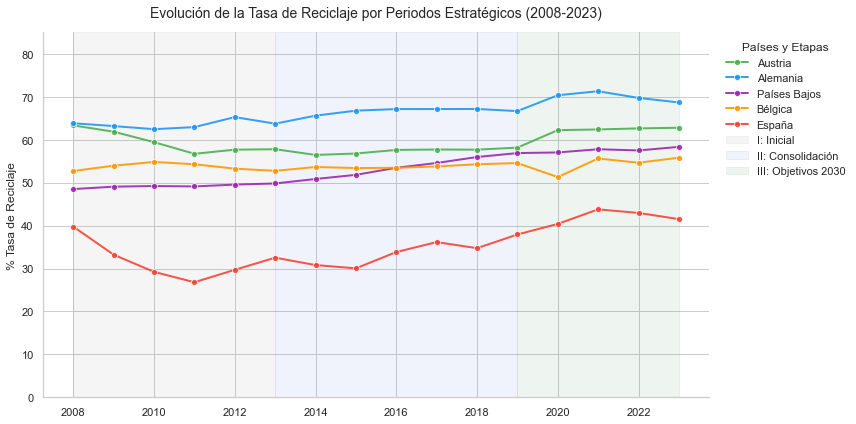

In [29]:
paises_linea = ["Alemania", "Austria", "España", "Bélgica", "Países Bajos"]
paleta_paises = {
    "Alemania":      "#2196F3",   # azul
    "Austria":       "#4CAF50",   # verde
    "España":        "#F44336",   # rojo
    "Bélgica":       "#FF9800",   # naranja
    "Países Bajos":  "#9C27B0",   # morado
}
df_linea = df_paises_ref[df_paises_ref["pais_eurostat"].isin(paises_linea)].sort_values("anyo")

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_linea, x="anyo", y="tasa_reciclaje_pct",
             hue="pais_eurostat", marker="o", linewidth=2,  palette=paleta_paises,  alpha=0.9)

periodos = [
    (2008, 2013, "gray",       "I: Inicial"),
    (2013, 2019, "royalblue",  "II: Consolidación"),
    (2019, 2023, "seagreen",   "III: Objetivos 2030"),
]
for inicio, fin, color, etiqueta in periodos:
    plt.axvspan(inicio, fin, color=color, alpha=0.08, label=etiqueta)

plt.title("Evolución de la Tasa de Reciclaje por Periodos Estratégicos (2008-2023)",
          fontsize=14, pad=15)
plt.ylabel("% Tasa de Reciclaje")
plt.xlabel(None)
plt.ylim(0, 85)
plt.legend(title="Países y Etapas", bbox_to_anchor=(1.01, 1), loc="upper left", frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig("fig06_informe_benchmarking_internacional.png", dpi=300, bbox_inches="tight")  # ← INFORME: 300 dpi
plt.show()

### Resultado — Benchmarking internacional

El análisis comparativo revela una **brecha de 20-25 puntos porcentuales** entre España y los países líderes europeos (Alemania, Austria, Bélgica), que se mantiene estable a lo largo de todo el período.

Puntos clave:
- **Alemania y Austria** superan el 60% de reciclaje de forma sostenida desde 2013, gracias a sistemas consolidados de separación en origen y redes densas de Puntos Limpios.
- **España** ha mejorado de 35% en 2008 a 40-42% en 2023, pero el ritmo de mejora es insuficiente para alcanzar la meta europea del 55% en 2025.
- La brecha no es solo de infraestructura: los países líderes han combinado **incentivos económicos** (tasas por generación de residuos mezclados) con **campañas culturales** de largo plazo.

**El AMB** presenta un desempeño ligeramente mejor que la media española, pero necesita acelerar el ritmo de mejora de forma significativa para cumplir con los Objetivos 2030 de la UE.

In [30]:
# 1. Preparación de datos (Manteniendo nombres de objetos originales)
anio_ultimo_paises = int(df_paises_ref["anyo"].max())

df_comp_display = df_paises_ref[df_paises_ref["anyo"] == anio_ultimo_paises][[
    "pais_eurostat", "generacion_tot", "tasa_reciclaje_pct",
    "tasa_vertido_pct", "tasa_incineracion_pct", "tasa_no_tratamiento_pct", "g_gob_central"
]].sort_values("tasa_reciclaje_pct", ascending=False).rename(columns={
    "pais_eurostat": "País", 
    "generacion_tot": "Generación (kg/hab)",
    "tasa_reciclaje_pct": "Reciclaje (%)", 
    "tasa_vertido_pct": "Vertido (%)",
    "tasa_incineracion_pct": "Incineración (%)",
    "tasa_no_tratamiento_pct": "No tratamiento (%)",
    "g_gob_central": "Gasto (% PIB)"
})

df_comp_display = df_comp_display.drop(columns=["No tratamiento (%)"])

# colores
cols_gestion_buenas  = ["Reciclaje (%)"]
cols_gestion_malas   = ["Vertido (%)"]
cols_gestion_neutras = ["Incineración (%)"]

styled_table = df_comp_display.style.format({
    "Reciclaje (%)":     "{:.1f}%",
    "Vertido (%)":       "{:.1f}%",
    "Incineración (%)":  "{:.1f}%",
    "Generación (kg/hab)": "{:,.0f}",
    "Gasto (% PIB)":     "{:.1f}%"
}).background_gradient(
    cmap="Blues",   subset=["Generación (kg/hab)"], vmin=0, vmax=900
).background_gradient(
    cmap="Greens",  subset=cols_gestion_buenas,  vmin=0, vmax=100
).background_gradient(
    cmap="Reds",    subset=cols_gestion_malas,   vmin=0, vmax=100
).background_gradient(
    cmap="Oranges", subset=cols_gestion_neutras, vmin=0, vmax=100
).background_gradient(
    cmap="Purples", subset=["Gasto (% PIB)"],    vmin=0, vmax=1
).hide(axis="index").set_caption(
    f"Benchmarking Internacional de Gestión de Residuos ({anio_ultimo_paises})"
).set_table_styles([
    {"selector": "caption",
     "props": [("color", "#333"), ("font-size", "16px"),
               ("font-weight", "bold"), ("padding", "10px")]},
    {"selector": "th",
     "props": [("background-color", "#f4f4f4"),
               ("color", "black"), ("border", "1px solid #dee2e6")]}
])

styled_table


País,Generación (kg/hab),Reciclaje (%),Vertido (%),Incineración (%),Gasto (% PIB)
Alemania,613,68.7%,1.0%,30.3%,0.2%
Austria,782,62.8%,1.8%,35.4%,0.1%
Países Bajos,468,58.3%,1.3%,40.2%,0.6%
Bélgica,688,55.8%,0.1%,44.0%,0.4%
Dinamarca,759,46.6%,1.8%,51.0%,0.0%
España,465,41.5%,48.0%,10.5%,0.6%
Suecia,392,39.3%,1.0%,58.7%,0.1%


In [31]:
#df_municipios[df_municipios["anio"] == 2023]["eficiencia_reciclaje_pct"].mean() # promedio AMB
df_municipios.groupby("anio")["eficiencia_reciclaje_pct"].mean()

anio
2008    41.858427
2009    45.156015
2010    46.364039
2011    46.406136
2012    45.215749
2013    42.670219
2014    44.366618
2015    44.315572
2016    44.190217
2017    44.219008
2018    46.643865
2019    48.770050
2020    49.895971
2021    50.245801
2022    51.250690
2023    53.227763
Name: eficiencia_reciclaje_pct, dtype: float64

In [32]:
df_bcn.columns
# 1. Preparación de datos — Barcelona
anio_ultimo_bcn = int(df_bcn["anio"].max())

df_bcn_display = df_bcn[df_bcn["anio"] == anio_ultimo_bcn][[
    "anio", "generac_kg_per_hab", "eficiencia_reciclaje_pct", "gasto_res_pct_pib"
]].rename(columns={
    "anio":                    "Año",
    "generac_kg_per_hab":      "Generación (kg/hab)",
    "eficiencia_reciclaje_pct": "Reciclaje (%)",
    "gasto_res_pct_pib":       "Gasto (% PIB)"
})

# Colores
styled_table_bcn = df_bcn_display.style.format({
    "Reciclaje (%)":          "{:.1f}%",
    "Generación (kg/hab)":    "{:,.0f}",
    "Gasto (% PIB)":          "{:.1f}%"
}).background_gradient(
    cmap="Blues",   subset=["Generación (kg/hab)"], vmin=0, vmax=900
).background_gradient(
    cmap="Greens",  subset=["Reciclaje (%)"],        vmin=0, vmax=100
).background_gradient(
    cmap="Purples", subset=["Gasto (% PIB)"],        vmin=0, vmax=1
).hide(axis="index").set_caption(
    f"Gestión de Residuos en Barcelona ({anio_ultimo_bcn})"
).set_table_styles([
    {"selector": "caption",
     "props": [("color", "#333"), ("font-size", "16px"),
               ("font-weight", "bold"), ("padding", "10px")]},
    {"selector": "th",
     "props": [("background-color", "#f4f4f4"),
               ("color", "black"), ("border", "1px solid #dee2e6")]}
])

styled_table_bcn



Año,Generación (kg/hab),Reciclaje (%),Gasto (% PIB)
2023,440,40.8%,0.1%


### Resultado — Tabla comparativa internacional (2023)

La tabla revela que la gestión de residuos en Europa no sigue un patrón único: países con generación similar pueden tener tasas de reciclaje muy distintas, y países que gastan lo mismo obtienen resultados opuestos.

**El problema de España no es cuánto genera, sino qué hace con ello.**
**El vertido es el indicador más crítico y el que más aísla a España.**
**La incineración como termómetro de madurez del sistema.**: Los países que han eliminado el vertido han canalizado ese flujo hacia incineración con recuperación energética.
**La paradoja del gasto: España invierte como Países Bajos pero recicla 17 puntos menos.**
**Dinamarca y Suecia: el aviso de que ser rico no es suficiente.**: están por debajo de la meta UE del 55%
**Para el AMB**, esto es una advertencia: construir infraestructura de incineración como alternativa al vertido no es suficiente si no va acompañada de sistemas robustos de reciclaje.

**Síntesis para el AMB:**
La brecha no es de recursos —España gasta tanto como los mejores— sino de tres déficits concretos: (1) infraestructura insuficiente de recogida de residuos en origen, (2) ausencia de sistemas de incentivo económico al ciudadano (depósito-retorno, pago por generación), y (3) dependencia estructural del vertedero como destino por defecto. Los tres son
abordables con decisión política y reasignación del gasto existente, sin necesidad de incremento presupuestario.
